In [1]:
import pandas as pd
import numpy as np
import json
import os
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

In [2]:
sns.set_palette("colorblind")

# Data Loading

In [3]:
pwd = "."
figs_dir = "./figs"
!mkdir -p figs

In [4]:
nbs = [
  "lextoumbourou/feedback3-eda-hf-custom-trainer-sift",
  "paultimothymooney/kaggle-survey-2022-all-results",
  "dataranch/supermarket-sales-prediction-xgboost-fastai",
  "kkhandekar/environmental-vs-ai-startups-india-eda",
  "ampiiere/animal-crossing-villager-popularity-analysis",
  "aieducation/what-course-are-you-going-to-take",
  "saisandeepjallepalli/adidas-retail-eda-data-visualization",
  "joshuaswords/netflix-data-visualization",
  "spscientist/student-performance-in-exams",
  "ibtesama/getting-started-with-a-movie-recommendation-system",

  "nickwan/creating-player-stats-using-tracking-data",
  "erikbruin/nlp-on-student-writing-eda",
  "madhurpant/beautiful-kaggle-2022-analysis",
  "pmarcelino/comprehensive-data-exploration-with-python",
  "gksriharsha/eda-speedtests",
  "mpwolke/just-you-wait-rishi-sunak",
  "sanket7994/imdb-dataset-eda-project",
  "roopacalistus/retail-supermarket-store-analysis",
  "sandhyakrishnan02/indian-startup-growth-analysis",
  "roopacalistus/exploratory-data-analysis-retail-supermarket"
]
nb_labels = [
  "feedb-eda-hf-sift",
  "kaggle-survey-2022",
  "sales-pred-xgboost",
  "env-ai-startups-eda",
  "animal-crossing",
  "course-prediction",
  "adidas-retail-eda",
  "netflix-data-viz",
  "student-perf",
  "movie-recomm",

  "player-stats-tracking",
  "nlp-stud-writ-eda",
  "kaggle-2022-analysis",
  "data-expl-with-python",
  "eda-speedtests",
  "just-you-wait-rishi-sunak",
  "imdb-dataset-eda",
  "smarket-store-analysis",
  "indian-startup-growth",
  "eda-retail-supermarket"
]

def only_hits_nb(df):
  assert (type(df) == pd.DataFrame or type(df) == pd.Series or type(df) == pd.Index)
  return df[:10]

def only_hits_cell(df):
  assert (type(df) == pd.DataFrame or type(df) == pd.Series)
  hits = [s for s in df.index if int(s.split('_')[1]) < 10]
  return df.loc[hits]

def ns_to_ms(ns):
  return ns / 1_000_000

num_runs = 10
len(nbs)

20

In [5]:
def read_stats(version, read_mem=True):
  cell_to_all_runs = {}
  nb_to_mem_runs = {}
  for nb_idx, nb in enumerate(nbs):
    for r in range(num_runs):
      nb_filename = '_'.join(nb.split('/')) + '.json'
      filepath = f"{pwd}/{version}/s-{r}/{nb_filename}"
      fp = open(filepath, 'r')
      d = json.load(fp)
      fp.close()
      nb_mem_key = f'NB_{nb_idx}'
      if read_mem:
        # Store Memory Results. One per notebook
        try:
          nb_to_mem_runs[nb_mem_key].append(d['max-mem-in-mb'])
        except:
          nb_to_mem_runs[nb_mem_key] = [d['max-mem-in-mb']]
      # Store timing results. One per cell.
      for c_idx, c in enumerate(d['cells']):
        key = f"C_{nb_idx}_{c_idx}"
        cell_time = ns_to_ms(c['total-ns'])
        try:
          cell_to_all_runs[key].append(cell_time)
        except:
          cell_to_all_runs[key] = [cell_time]

  ### Verify all cells have same number of timings ###
  keys = list(cell_to_all_runs)
  for i in range(len(keys)):
    for j in range(i+1, len(keys)):
      ki = keys[i]
      kj = keys[j]
      vi = cell_to_all_runs[ki]
      vj = cell_to_all_runs[kj]
      assert len(vi) == len(vj)

  time_df = pd.DataFrame(cell_to_all_runs)
  if read_mem:
    mem_df = pd.DataFrame(nb_to_mem_runs)
  else:
    mem_df = None
  return time_df, mem_df

In [6]:
def read_modin_stats(version):
  cell_to_all_runs = {}
  nb_to_mem_runs = {}
  for nb_idx, nb in enumerate(nbs):
    for r in range(num_runs):
      nb_filename = '_'.join(nb.split('/')) + '.json'
      nb_timing_filepath = f"{pwd}/{version}/s-{r}/{nb_filename}"
      timing_fp = open(nb_timing_filepath, 'r')
      timing_d = json.load(timing_fp)
      timing_fp.close()
      
      mem_split = version.split("_")
      mem_suff = mem_split[-1]
      assert mem_suff == "OFF"
      mem_suff = "ON"
      mem_version = "_".join(mem_split[:-1] + [mem_suff])
      nb_mem_filepath = f"{pwd}/{mem_version}/s-{r}/{nb_filename}"
      mem_fp = open(nb_mem_filepath, 'r')
      mem_d = json.load(mem_fp)
      mem_fp.close()
      
      
      nb_mem_key = f'NB_{nb_idx}'
      # Store Memory Results. One per notebook
      try:
        nb_to_mem_runs[nb_mem_key].append(mem_d['max-mem-in-mb'])
      except:
        nb_to_mem_runs[nb_mem_key] = [mem_d['max-mem-in-mb']]
      # Store timing results. One per cell.
      for c_idx, c in enumerate(timing_d['cells']):
        key = f"C_{nb_idx}_{c_idx}"
        cell_time = ns_to_ms(c['total-ns'])
        try:
          cell_to_all_runs[key].append(cell_time)
        except:
          cell_to_all_runs[key] = [cell_time]

  ### Verify all cells have same number of timings ###
  keys = list(cell_to_all_runs)
  for i in range(len(keys)):
    for j in range(i+1, len(keys)):
      ki = keys[i]
      kj = keys[j]
      vi = cell_to_all_runs[ki]
      vj = cell_to_all_runs[kj]
      assert len(vi) == len(vj)

  time_df = pd.DataFrame(cell_to_all_runs)
  mem_df = pd.DataFrame(nb_to_mem_runs)
  return time_df, mem_df

In [7]:
# All versions have the raw cells. Pick one at random and get the raw.
def find_raw(cell_name):
  spl = cell_name.split('_')
  search_nb_idx = int(spl[1])
  search_cell_idx = int(spl[2])
  nb = nbs[search_nb_idx]
  print(f"--- {nb} ---")
  nb_filename = '_'.join(nb.split('/')) + '.json'
  random_run = 4
  filepath = f"{pwd}/stats-rewr_OFF-modin_OFF-repl_STD-sliced_exec_ON/s-{random_run}/{nb_filename}"
  fp = open(filepath, 'r')
  d = json.load(fp)
  fp.close()
  for c_idx, c in enumerate(d['cells']):
    if c_idx == search_cell_idx:
      return c['raw']
  assert 0

# Rewriter vs Pandas

In [8]:
orig, _ = read_stats("stats-rewr_OFF-modin_OFF-repl_STD-modin_mem_OFF")
rewr, _ = read_stats("stats-rewr_ON-modin_OFF-repl_STD-modin_mem_OFF")

In [9]:
orig

,C_0_0,C_0_1,C_0_2,C_0_3,C_0_4,C_0_5,C_0_6,C_0_7,C_0_8,C_0_9,...,C_19_17,C_19_18,C_19_19,C_19_20,C_19_21,C_19_22,C_19_23,C_19_24,C_19_25,C_19_26
0,164.114438,56.056826,54.225459,0.336344,0.138492,0.142502,0.148292,145.609670,236.498562,274.485284,...,0.067861,0.521817,0.093341,1.307669,0.121671,0.071181,0.054451,0.052611,1.400879,1.309049
1,161.460919,56.464774,53.942518,0.336025,0.138742,0.139282,0.149732,148.460798,237.670367,270.181057,...,0.067331,0.519557,0.072251,1.175767,0.116331,0.063371,0.054231,0.051651,1.385769,1.301778
2,162.662757,56.044048,53.857639,0.350605,0.139872,0.141862,0.148592,146.548157,234.191937,270.680128,...,0.066901,0.516307,0.073131,1.192976,0.115532,0.064121,0.055910,0.052611,1.410760,1.296628
3,161.918280,54.693972,52.771697,0.338985,0.141112,0.138682,0.148962,146.877450,230.893318,267.480861,...,0.067021,0.516237,0.071791,1.148436,0.113132,0.062300,0.054211,0.051141,1.393129,1.247158
4,161.669208,54.121826,52.521504,0.343145,0.136921,0.137232,0.149773,145.362414,232.373351,268.053324,...,0.066561,0.511396,0.071831,1.134833,0.112311,0.063241,0.053411,0.052290,1.404477,1.282195
5,163.254800,57.448480,53.576994,0.339144,0.135951,0.139282,0.156652,148.409855,236.616509,273.812319,...,0.065061,0.504346,0.071381,1.105895,0.110111,0.062381,0.053121,0.050950,1.333768,1.253056
6,161.023633,56.374713,53.087530,0.334874,0.136072,0.137062,0.143702,146.272012,235.117285,265.585633,...,0.067551,0.510617,0.073031,1.148256,0.115251,0.065181,0.055741,0.052510,1.374317,1.281536
7,164.400804,54.731631,53.199449,0.335314,0.137152,0.136082,0.143991,144.853294,233.365335,267.650072,...,0.066861,0.516827,0.072531,1.145515,0.112682,0.063261,0.053050,0.052401,1.355188,1.303268
8,159.488425,53.197645,52.751269,0.339055,0.131332,0.143782,0.140982,143.233787,229.479996,266.247942,...,0.067791,0.511257,0.073781,1.153066,0.117972,0.065680,0.056780,0.055181,1.424829,1.306609
9,162.949747,55.215612,53.929634,0.337524,0.136262,0.140032,0.149222,148.174174,233.262046,273.646324,...,0.067021,0.517407,0.073711,1.174026,0.117842,0.063761,0.057390,0.053081,1.395669,1.319208


## Discard Very Fast Cells

In [10]:
cells_to_drop = []
for c in orig.columns:
  if orig[c].mean() < 50:
    orig = orig.drop(c, axis=1)
    rewr = rewr.drop(c, axis=1)
    cells_to_drop.append(c)

print(len(rewr.columns))

250


## Coefficient of Variation

<AxesSubplot:>

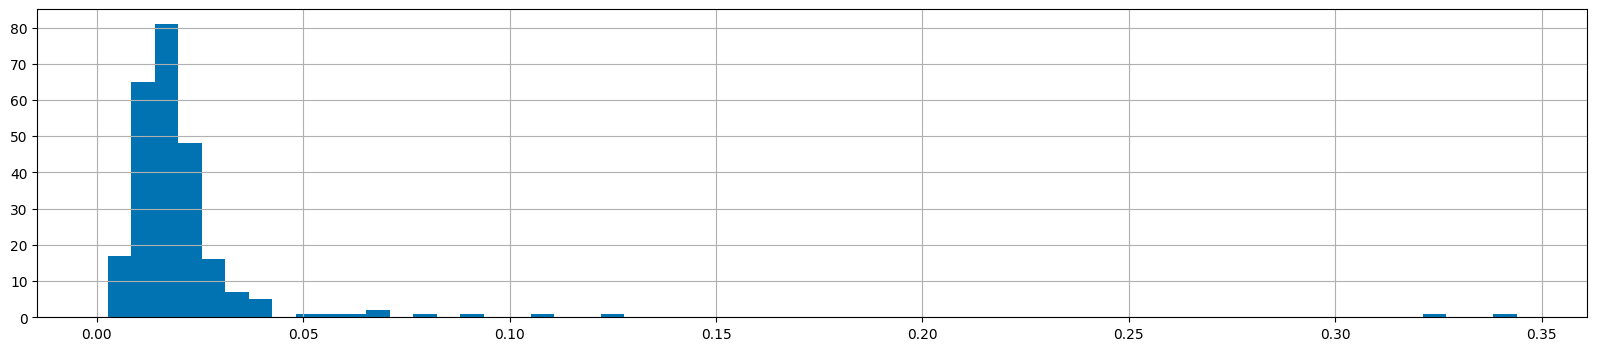

In [11]:
# Coefficient of variation
def coef_of_var(df):
  return df.apply(lambda cell: cell.std() / cell.mean())

CV_orig = coef_of_var(orig)
CV_orig.hist(bins=60, figsize=(20, 4))

## Geomean Difference

In [12]:
mean_orig = orig.apply(lambda cell: cell.mean())
mean_rewr = rewr.apply(lambda cell: cell.mean())
mean_diff = mean_orig - mean_rewr
mean_df = pd.DataFrame({'Mean Diff': mean_diff})

In [13]:
mean_df['Std. Dev.'] = mean_df.apply(lambda c: orig[c.name].std(), axis=1)

### Largest Speedups

In [14]:
mean_df.nlargest(n=20, columns='Mean Diff')

,Mean Diff,Std. Dev.
C_2_10,8640.726778,38.426395
C_8_17,4875.460228,146.328179
C_5_9,2834.462397,59.481280
C_1_18,1353.661332,74.546860
C_5_22,998.535591,35.204391
C_6_19,969.325162,23.427903
C_7_13,797.058586,59.521006
C_6_18,711.454211,17.904211
C_6_14,535.055144,12.017534
C_1_9,388.126717,31.534121


### Largest Slowdowns

In [15]:
largest_abs_slowdowns = mean_df.nsmallest(n=10, columns='Mean Diff')
largest_abs_slowdowns

,Mean Diff,Std. Dev.
C_9_18,-8876.549144,3298.320926
C_15_9,-396.072493,785.222685
C_1_30,-167.015499,23.488082
C_14_24,-145.090671,108.119468
C_1_27,-135.680843,10.637838
C_14_14,-120.695661,85.959780
C_5_11,-82.551637,7.847848
C_17_12,-69.135172,2.760462
C_11_29,-33.507338,195.557674
C_17_5,-32.517871,35.285951


## Relative Speedups

59


<AxesSubplot:xlabel='Cells', ylabel='Relative Speedup'>

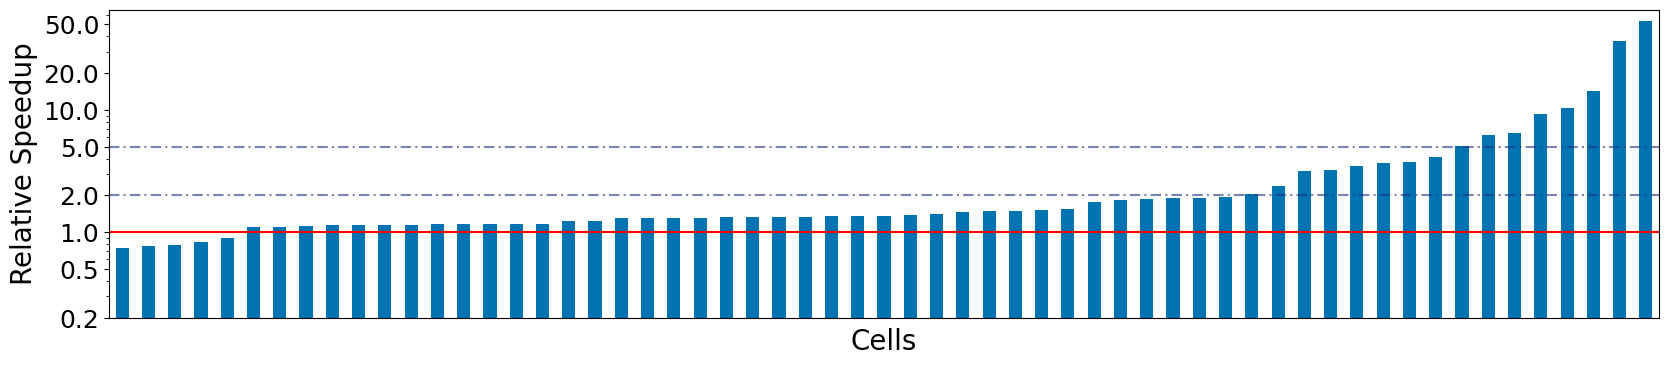

In [16]:
mean_speedup = mean_orig / mean_rewr
mean_speedup = only_hits_cell(mean_speedup)
index_to_nums = mean_speedup.reset_index().drop('index', axis=1)
index_to_nums = index_to_nums.sort_values(by=0)[0]
drop_within_10_perc = index_to_nums.drop(index_to_nums[(0.9 < index_to_nums) & (index_to_nums < 1.1)].index)

print(len(drop_within_10_perc))

thing_to_plot = drop_within_10_perc
ax = thing_to_plot.plot(kind="bar", figsize=(20, 4) )

ax.axhline(1, color='red')
ax.axhline(2, color=(0.1, 0.2, 0.5, 0.6), dashes=(5, 2, 1, 2))
ax.axhline(5, color=(0.1, 0.2, 0.5, 0.6), dashes=(5, 2, 1, 2))

ax.yaxis.set_tick_params(labelsize=18)

ax.set_xlabel("Cells", fontsize=20)
ax.set_ylabel("Relative Speedup", fontsize=20)

ax.set_yscale("log")

ax.set_xticks([])
ax.set_yticks([0.2, 0.5, 1, 2, 5, 10, 20, 50])
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
# ax.set_xticks([])
plt.savefig(f'{figs_dir}/cell_level.pdf', bbox_inches='tight')
ax

<AxesSubplot:xlabel='Cells', ylabel='Relative Speedup'>

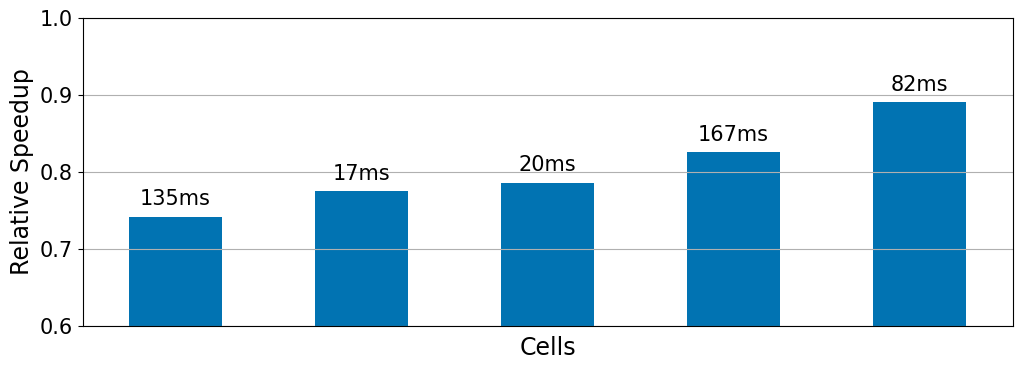

In [17]:
only_cell_slowdowns = mean_speedup.drop(mean_speedup[(0.9 < mean_speedup)].index)
only_cell_slowdowns = only_cell_slowdowns.sort_values()

# ax = only_cell_slowdowns.plot(kind="bar", figsize=(6, 2), color=(56/255, 176/255, 194/255, 1))
# ax = only_cell_slowdowns.plot(kind="bar", figsize=(8, 2), color=(183/255, 19/255, 104/255, 1))
ax = only_cell_slowdowns.plot(kind="bar", figsize=(12, 4))
ax.set_ylabel('Relative Speedup', fontsize=17)
ax.set_xlabel('Cells', fontsize=17)
# ax.axhline(1, color='red')
ax.yaxis.set_tick_params(labelsize=15)
ax.grid(visible=True, axis='y')
plt.ylim(top=1.0, bottom=0.6)
ax.set_xticks([])
ax.set_yticks([x for x in np.arange(0.6, 1.0 + 0.001, 0.1)])

rects = ax.patches

abs_values = [-mean_df.loc[i]['Mean Diff'] for i in only_cell_slowdowns.index]

for rect, label in zip(rects, abs_values):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 0.01, str(int(label)) + "ms", ha="center", va="bottom", fontsize=15
    )


plt.savefig(f'{figs_dir}/cells_only_slowdowns.pdf', bbox_inches='tight', pad_inches=0)
ax

In [18]:
mean_speedup.nlargest(10)

C_9_8     53.461718
C_8_17    36.410398
C_2_10    14.241791
C_0_0     10.353003
C_7_0      9.341391
C_6_18     6.437037
C_6_19     6.280558
C_1_9      5.100360
C_6_14     4.145533
C_6_73     3.772262
dtype: float64

In [19]:
mean_speedup.nsmallest(10)

C_1_27    0.741397
C_1_28    0.774496
C_1_29    0.785610
C_1_30    0.825123
C_5_11    0.890196
C_1_5     0.946397
C_1_37    0.948555
C_9_18    0.959618
C_1_17    0.969907
C_1_39    0.972396
dtype: float64

## Geomean Per-Cell Relative Speedup

In [20]:
stats.gmean(mean_speedup)

1.285614228387838

## Whole Notebooks

In [21]:
max_nb = max([int(nb.split("_")[1]) for nb in orig.columns])
def get_whole_mean(df):
    nb_means = []
    for i in range(max_nb + 1):
        # All columns (i.e., cells) of the i-th notebook
        col_set = [col for col in df.columns if col.split("_")[1] == str(i)]
        # Sum horizontally. Each element of the resulting Series is one run of the whole notebook
        nb_runs = df[col_set].sum(axis=1)
        # Take the mean (across runs)
        nb_means.append(nb_runs.mean())
    
    return pd.Series(nb_means)

In [22]:
orig_whole = get_whole_mean(orig)
rewr_whole = get_whole_mean(rewr)

<AxesSubplot:xlabel='Notebooks', ylabel='Relative Speedup'>

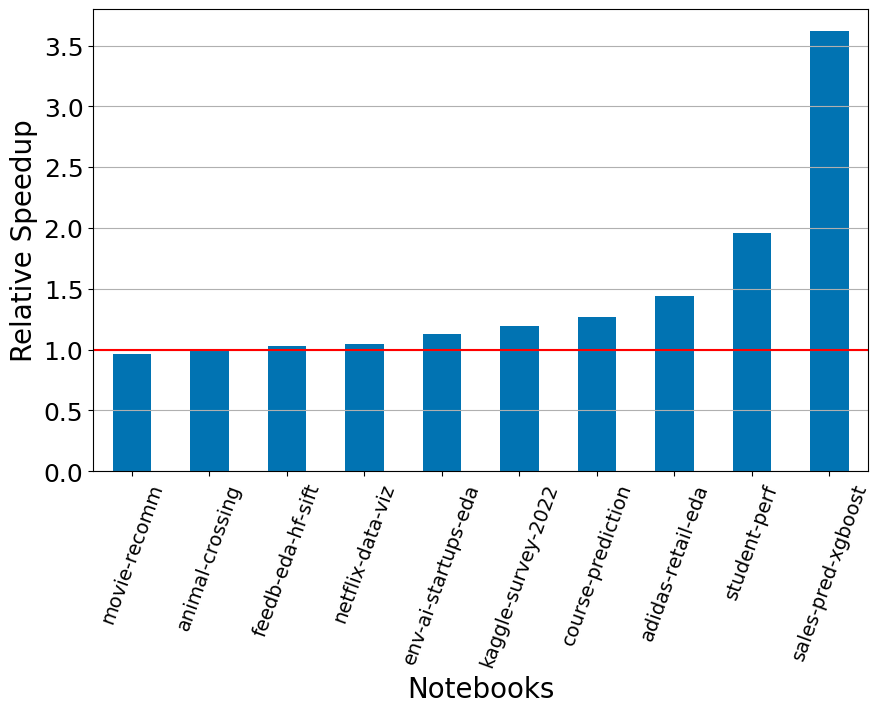

In [23]:
mean_whole_speedup = orig_whole / rewr_whole

mean_whole_speedup = only_hits_nb(mean_whole_speedup)

new_index = []
for nb_idx in mean_whole_speedup.index:
  new_index.append(nb_labels[nb_idx])
mean_whole_speedup.index = pd.Series(new_index)

to_plot_sorted = mean_whole_speedup.sort_values()
ax = to_plot_sorted.plot(kind="bar", figsize=(10, 6) )
ax.set_ylabel('Relative Speedup', fontsize=20)
ax.set_xlabel('Notebooks', fontsize=20)
ax.axhline(1, color='red')
ax.grid(visible=True, axis='y')
ax.yaxis.set_tick_params(labelsize=18)
plt.xticks(rotation=70, fontsize=14)
plt.savefig(f'{figs_dir}/nb_level.pdf', bbox_inches='tight')
ax

In [24]:
mean_whole_speedup.sort_values()

movie-recomm           0.963732
animal-crossing        1.008266
feedb-eda-hf-sift      1.029160
netflix-data-viz       1.044768
env-ai-startups-eda    1.123997
kaggle-survey-2022     1.196878
course-prediction      1.265376
adidas-retail-eda      1.439356
student-perf           1.962067
sales-pred-xgboost     3.618378
dtype: float64

## Geomean Per-NB Relative Speedup

In [25]:
stats.gmean(mean_whole_speedup)

1.336430894362949

# Compare with Modin

In [26]:
base_less_repl, mem_base = read_stats("stats-rewr_OFF-modin_OFF-repl_LESS-modin_mem_OFF")
rewr_less_repl, mem_rewr = read_stats("stats-rewr_ON-modin_OFF-repl_LESS-modin_mem_OFF")
modin_12, mem_modin12 = read_modin_stats("stats-rewr_OFF-modin_12-repl_LESS-modin_mem_OFF")
modin_8, mem_modin8 = read_modin_stats("stats-rewr_OFF-modin_8-repl_LESS-modin_mem_OFF")
modin_4, mem_modin4 = read_modin_stats("stats-rewr_OFF-modin_4-repl_LESS-modin_mem_OFF")

In [27]:
_mod_mean_base = base_less_repl.apply(lambda cell: cell.mean())
_mod_mean_rewr = rewr_less_repl.apply(lambda cell: cell.mean())
_mod_mean_modin12 = modin_12.apply(lambda cell: cell.mean())
_mod_mean_modin8 = modin_8.apply(lambda cell: cell.mean())
# _mod_mean_modin4 = modin_4.apply(lambda cell: cell.mean())


_mod_rewr_diff = _mod_mean_base - _mod_mean_rewr
_mod_modin12_diff = _mod_mean_base - _mod_mean_modin12
_mod_mean_df = pd.DataFrame({'Mean Rewr': _mod_rewr_diff, 'Mean Modin-12': _mod_modin12_diff})

In [28]:
_mod_mean_df.nlargest(n=10, columns='Mean Modin-12')

,Mean Rewr,Mean Modin-12
C_9_18,-2917.931503,55089.124544
C_16_1,-26.735604,6066.737236
C_0_10,49.831665,3599.339005
C_8_17,4874.198390,2884.432767
C_5_8,53.127404,2346.921004
C_5_14,-7.589898,2041.313231
C_13_14,-59.698012,1725.484591
C_6_19,973.343708,1133.417460
C_6_10,5.562710,1079.338940
C_6_18,712.112620,820.806651


In [29]:
(_mod_mean_modin12 / _mod_mean_rewr).max()

2410.4545604536183

## Whole Notebooks

In [30]:
_mod_base_whole = get_whole_mean(base_less_repl)
_mod_rewr_whole = get_whole_mean(rewr_less_repl)
_mod_mod12_whole = get_whole_mean(modin_12)
_mod_mod8_whole = get_whole_mean(modin_8)
# _mod_mod4_whole = get_whole_mean(modin_4)

<AxesSubplot:xlabel='Notebooks', ylabel='Relative Speedup'>

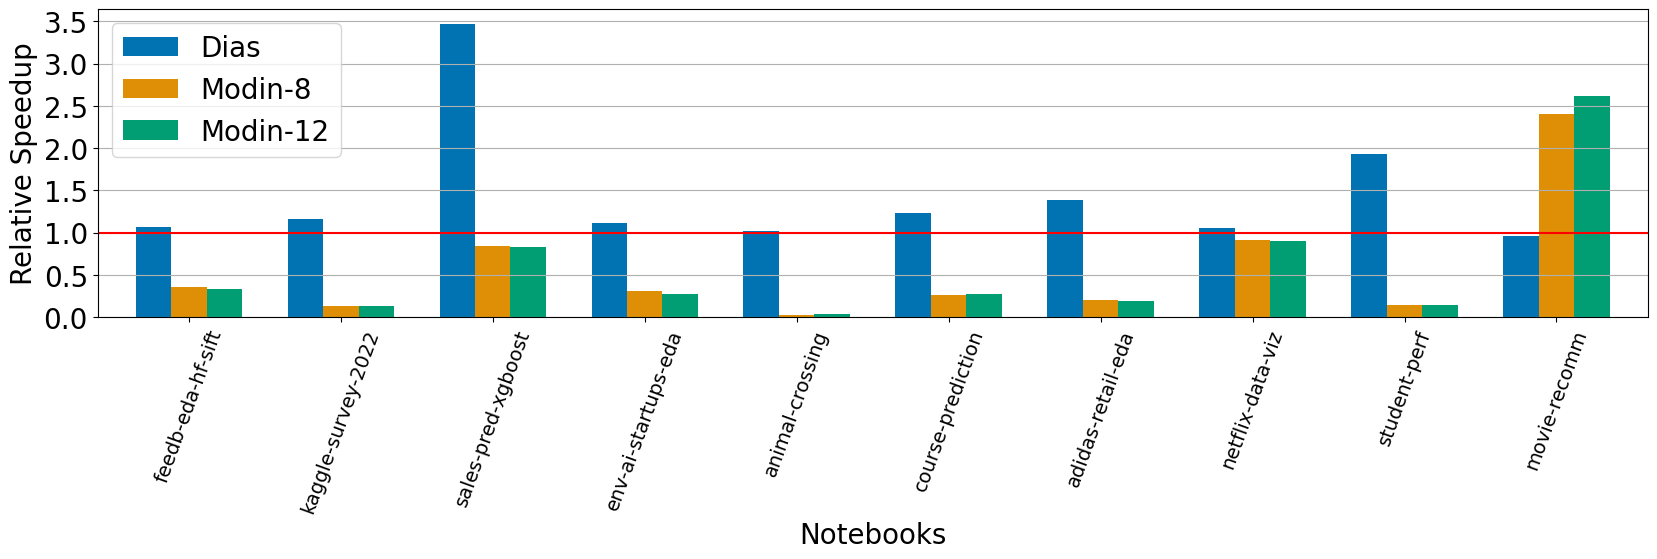

In [31]:
_mod_gmean_rewr_whole_speedup = _mod_base_whole / _mod_rewr_whole
_mod_gmean_mod12_whole_speedup = _mod_base_whole / _mod_mod12_whole
_mod_gmean_mod8_whole_speedup = _mod_base_whole / _mod_mod8_whole
# _mod_gmean_mod4_whole_speedup = _mod_base_whole / _mod_mod4_whole
whole_nb_df = pd.DataFrame({'Dias': _mod_gmean_rewr_whole_speedup, 
#                             'Modin-4': _mod_gmean_mod4_whole_speedup,
                            'Modin-8': _mod_gmean_mod8_whole_speedup,
                            'Modin-12': _mod_gmean_mod12_whole_speedup
                            })

whole_nb_df = only_hits_nb(whole_nb_df)

new_index = []
for nb_idx in whole_nb_df.index:
  new_index.append(nb_labels[nb_idx])
whole_nb_df = whole_nb_df.set_index(pd.Series(new_index))


ax = whole_nb_df.plot(kind="bar", width=0.7, figsize=(20, 4) )
ax.set_ylabel('Relative Speedup', fontsize=20)
ax.set_xlabel('Notebooks', fontsize=20)
ax.axhline(1, color='red')
ax.set_yticks([x for x in np.arange(0, 3.6, 0.5)])
ax.grid(visible=True, axis='y')
ax.yaxis.set_tick_params(labelsize=20)
ax.legend(fontsize=20)
plt.xticks(rotation=70, fontsize=14)
plt.savefig(f'{figs_dir}/modin_nb.pdf', bbox_inches='tight')
ax

## Summary Numbers vs Modin

In [32]:
speedup_vs_modin = (_mod_mod12_whole / _mod_rewr_whole)

In [33]:
speedup_vs_modin.max()

30.125632665093868

In [34]:
stats.gmean(speedup_vs_modin)

4.521810876261561

# Memory Consumption

In [35]:
mean_mem_base = mem_base.apply(lambda nb: nb.mean())
mean_mem_rewr = mem_rewr.apply(lambda nb: nb.mean())
mean_mem_modin4 = mem_modin4.apply(lambda nb: nb.mean())
rewr_mem_diff = mean_mem_rewr - mean_mem_base
modin4_mem_diff = mean_mem_modin4 - mean_mem_base
mean_mem_df = pd.DataFrame({'SYSTEM': rewr_mem_diff, 'Modin-4': modin4_mem_diff})

In [36]:
# Mem Usage .csv
mean_mem_df = pd.DataFrame({'Pandas': mean_mem_base, 'Modin-4': mean_mem_modin4, 'Dias': mean_mem_rewr})
mean_mem_df.to_csv(f'{figs_dir}/test.csv')

In [37]:
mean_mem_df = only_hits_nb(mean_mem_df)

In [38]:
# Remove those we could not measure
mean_mem_df = mean_mem_df.loc[mean_mem_modin4 != -1]
mean_mem_df

,Pandas,Modin-4,Dias
NB_0,269.6,6060.2,266.7
NB_1,1041.7,4896.8,931.6
NB_2,525.0,0.0,551.1
NB_3,2011.7,3060.9,2056.2
NB_4,2250.0,13135.1,2250.8
NB_5,2822.7,16960.8,2207.5
NB_6,689.7,90215.9,577.4
NB_7,4618.0,0.0,5660.0
NB_8,568.6,1527.6,566.6
NB_9,4511.3,13375.9,4525.9


In [39]:
# gmean_mem_df['Modin-4'] = 1 - gmean_mem_df['Modin-4']


In [40]:
new_index = []
for nb in mean_mem_df.index:
  nb_idx = int(nb.split('_')[1])
  new_index.append(nb_labels[nb_idx])
mean_mem_df_names = mean_mem_df.set_index(pd.Series(new_index))

for col in mean_mem_df_names.columns:
  mean_mem_df_names[col] = mean_mem_df_names[col] / 1024
mean_mem_df_names

,Pandas,Modin-4,Dias
feedb-eda-hf-sift,0.263281,5.918164,0.260449
kaggle-survey-2022,1.017285,4.782031,0.909766
sales-pred-xgboost,0.512695,0.000000,0.538184
env-ai-startups-eda,1.964551,2.989160,2.008008
animal-crossing,2.197266,12.827246,2.198047
course-prediction,2.756543,16.563281,2.155762
adidas-retail-eda,0.673535,88.101465,0.563867
netflix-data-viz,4.509766,0.000000,5.527344
student-perf,0.555273,1.491797,0.553320
movie-recomm,4.405566,13.062402,4.419824


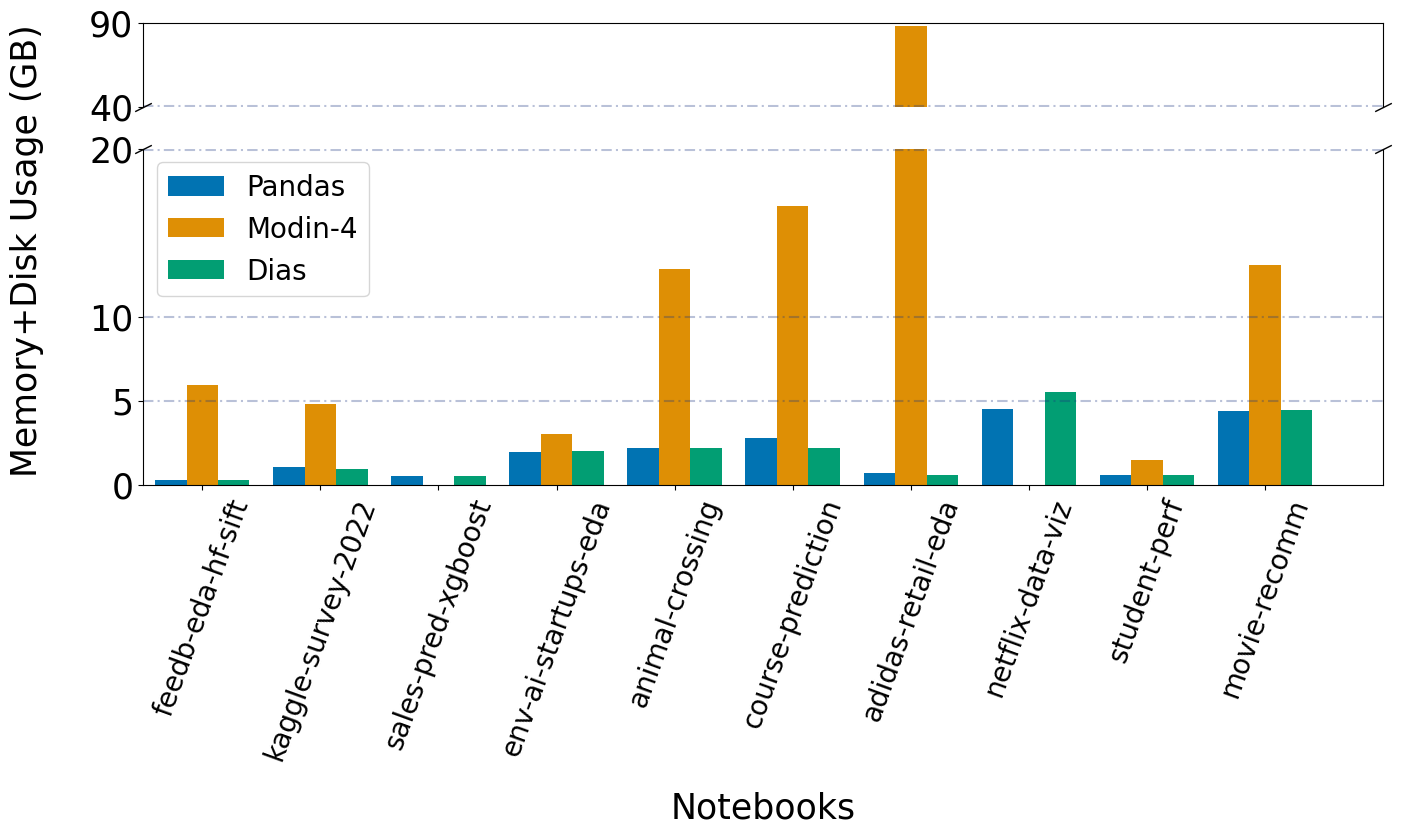

In [41]:
import matplotlib.gridspec as gridspec

nrows = 2
ncols = 1
gs = gridspec.GridSpec(nrows, ncols, height_ratios=[0.2, 0.8])
fig = plt.figure(figsize=(16, 6), dpi=100)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
fig.subplots_adjust(hspace=0.2)

# -.5 otherwise some bars are hidden on the left.
xlim = [-0.5, len(mean_mem_df_names)]
top_y = [40, 90]
bott_y = [0, 20]
ylim = [[], top_y, bott_y]

bar_width = 0.8

# three_colors = [(0.643, 0.424, 0.718, 1), (0.478, 0.643, 0.341, 1), (0.796, 0.416, 0.286, 1)]
# mean_mem_df_names.plot(kind='bar', width=bar_width, ax=ax1, legend=False, color=three_colors)
mean_mem_df_names.plot(kind='bar', width=bar_width, ax=ax1, legend=False)

ax1.set_xlim(*xlim)
ax1.set_ylim(*ylim[1])
# ax1.grid(color='lightgrey')

# mean_mem_df_names.plot(kind='bar', width=bar_width, ax=ax2, legend=True, color=three_colors)
mean_mem_df_names.plot(kind='bar', width=bar_width, ax=ax2, legend=True)
ax2.legend(fontsize=20)
ax2.set_xlim(*xlim)
ax2.set_ylim(*ylim[2])
ax2.set_xlabel('Notebooks', labelpad=20, fontsize=25)
ax2.set_ylabel('Memory+Disk Usage (GB)', fontsize=25)
# ax2.grid(color='lightgrey')
ax2.yaxis.set_label_coords(-0.08, 0.7)

ax2.xaxis.set_tick_params(labelsize=20, rotation=70)

ax1.yaxis.set_tick_params(labelsize=25)
ax2.yaxis.set_tick_params(labelsize=25)
# ax2.yaxis.offsetText.set_visible(False)
# ax2.yaxis.get_major_ticks()[0].label1.set_visible(False)
# ax2.ticklabel_format(axis='y', style='sci', scilimits=(6, 6))

ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.set_xticks([])

ax1.set_yticks([40, 90])
ax2.set_yticks([0, 5, 10, 20])

ax1.axhline(40+0.1, color=(0.1, 0.2, 0.5, 0.3), dashes=(5, 2, 1, 2))
ax2.axhline(20 - 0.1, color=(0.1, 0.2, 0.5, 0.3), dashes=(5, 2, 1, 2))
ax2.axhline(10, color=(0.1, 0.2, 0.5, 0.3), dashes=(5, 2, 1, 2))
ax2.axhline(5, color=(0.1, 0.2, 0.5, 0.3), dashes=(5, 2, 1, 2))

slant = 0.5
kwargs = dict(marker=[(-1, -slant), (1, slant)], markersize=12,
        linestyle='none', color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

plt.savefig(f'{figs_dir}/mem_usage.pdf', bbox_inches='tight')

In [42]:
rewr_mem_diff

NB_0       -2.9
NB_1     -110.1
NB_2       26.1
NB_3       44.5
NB_4        0.8
NB_5     -615.2
NB_6     -112.3
NB_7     1042.0
NB_8       -2.0
NB_9       14.6
NB_10       0.3
NB_11       0.5
NB_12      55.2
NB_13       0.2
NB_14       2.4
NB_15       1.2
NB_16       0.5
NB_17      66.8
NB_18      -9.9
NB_19       1.8
dtype: float64

In [43]:
rewr_mem_diff['NB_7']

1042.0

# Rewriter Stats

In [44]:
cell_rewr_stats = dict()
version = "stats-rewr_ON-modin_OFF-repl_STD-modin_mem_OFF"
for nb_idx, nb in enumerate(nbs):
  for r in range(num_runs):
    nb_filename = '_'.join(nb.split('/')) + '.json'
    filepath = f"{pwd}/{version}/s-{r}/{nb_filename}"
    fp = open(filepath, 'r')
    d = json.load(fp)
    fp.close()
    for c_idx, c in enumerate(d['cells']):
      key = f"C_{nb_idx}_{c_idx}"
      try:
        cell_rewr_stats[key].append(c)
      except:
        cell_rewr_stats[key] = [c]

## How Many Patterns We Needed

In [45]:
patts_needed = set()
for cell_key in cell_rewr_stats:
  cell = cell_rewr_stats[cell_key]
  for run in cell:
    patts_needed |= set(run['patts-hit'].keys())

len(patts_needed)

10

## Max and Mean Absolute Overheads (in any run)

In [46]:
# NOTE: We find the max overhead _in any run_, not means.

all_ohs = []
for cell_key in cell_rewr_stats:
  cell = cell_rewr_stats[cell_key]
  for run in cell:
    oh = ns_to_ms(run['overhead-ns'])
    all_ohs.append(oh)

max_oh = max(all_ohs)
print(f"Maximum Overhead: {max_oh: .2f}ms")
mean_oh = stats.gmean(all_ohs)
print(f"GMean Overhead: {mean_oh: .2f}ms")

Maximum Overhead:  45.98ms
GMean Overhead:  0.34ms


## Do we every slow down a rewritten cell (beyond interactive latency) ?

In [47]:
# Pretty small value for interactive latency
interactive_latency = 10
slowdown_rewr_cell = False

# Go through each cell in the stats. If we hit on this cell, then check the
# original stats and see if there's a difference outside the interactive
# latency.
for cell_key in cell_rewr_stats:
  if cell_key not in orig.columns:
    # Dropped as very fast. Skip
    continue
  # Get only one run. If we hit, we hit in all the runs.
  cell = cell_rewr_stats[cell_key][0]
  if cell['patts-hit'] != {}:
    diff = mean_rewr[cell_key] - mean_orig[cell_key]
    if diff > interactive_latency:
      print(f"Slowdown: {diff: .2f}")
      slowdown_rewr_cell = True

if not slowdown_rewr_cell:
  print("NO!")

NO!
